# Közlekedési hálózatok vizsgálata

In [3]:
from scipy.io import mmread
import konect2networkx as k2n
import networkx as nx
import matplotlib.pyplot as plt
import pprint

Közlekedési hálózatok gráfjait fogom vizsgálni feszítőfák segítségével. Generálok n darab feszítőfát és azon belül megnézem, hogy a különöző élek milyen valószínűséggel fordulnak elő a feszítőfákban. Ez által kaphatunk egy képet arról, hogy az adott hálózatban melyek a legnagyobb jelentőséggel bíró élek, azaz kapcsolatok.

## Gráf beolvasása fájlból

In [4]:
## import network
# param: internal name of the network (konect graph) or name of the file w extension (.mtx format only)
def network_graph(network):
    ext = network[len(network) - 4:]

    if (ext == ".mtx"):
        try:
          a = mmread(network)
          G = nx.Graph(a)
        except:
          print("Nincs ilyen .mtx fájl a mappában")
    else:
        try:
          G = k2n.get(network, download = True, logging = False)
        except:
          print("Nem létezik ilyen nevű konect gráf")
    
    return G

Jelenleg kétféle fájlformátumot fogad el a metódus: *.mtx* kiterjesztést vagy kiterjesztés nélküli konect gráfot. A konect gráfokat valójában csak egy string határozza meg, amit a *konect2networkx* függvénykönyvtár értelmez.<br>A visszatérési érték egy gráf lesz.

A függvény megvizsgálja a kiterjesztést, majd *mtx* fájl esetében megpróbálja beolvasni a fájlt abból a mappából, amiben a notebook is található. Ha nem találja, figyelmeztet a hibára. Ha kiterjesztés nélküli stringet adunk meg a paraméterben, konect gráfként értelmezi. Ha nem találja az adott nevű gráfot, hibát dob.

> TODO : más formátumokat is elfogadni (pl csv)

## 1. Uniform véletlen feszítőfák (UST) generálása

Egy gráfnak több feszítőfája is lehet. Egy véletlenszerűen kiválasztott feszítőfát nevezünk UST-nek.

In [5]:
# param: the graph, number of generated ust graphs(int)
def ust_matrix(G, n):
  orig_edges = list(G.edges())

  # initalizing 2d matrix 
  res = [[0 for i in range(0, G.number_of_edges())] for j in range(n + 1)]
    
  # copying the edge list into the first row of the matrix
  for i in range(G.number_of_edges()):
      res[0][i] = orig_edges[i]

  for i in range(1, n):
      # generating n number of ust graphs
      tree = nx.random_spanning_tree(G, None)
      tree_edges = list(tree.edges())
      for j in range(G.number_of_edges()):
          # checking if an edge is in the ust or not
          found = 0
          k = 0
          while k in range(0, tree.number_of_edges())  and  found == 0:
            if orig_edges[j] == tree_edges[k]:
                res[i][j] = 1
                found = 1
            k += 1

  return res

Paraméterben a gráfot kell megadni (amit a *network_graph()* metódus ad vissza) és egy számot, amennyi feszítőfát generálni akarunk.<br>A függvény egy 2D-s tömbbel, azaz egy mátrixszal tér vissza. Ennek a tömbnek az első sorában az eredeti gráf élei találhatóak, pontpárok segítségével megadva. Ezt értelmezzük egy táblázat fejléceként. A 2D-s tömb további sorai az egyes legenerált UST-ket jellemzi. A sorokban 0 vagy 1 található, aszerint, hogy a feszítőfába belekerült-e az az él, amit az adott oszlop fejléce leír.

#### Példa egy konect gráffal

[KONECT2NetworkX] Attemping to download network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] HTTP request successful, writing network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] Network successfully unpacked!


[(1, 6), (1, 7), (1, 8), (2, 7), (2, 8), (3, 6), (3, 9), (3, 10), (4, 6), (4, 9), (4, 7), (5, 9), (5, 8), (5, 10)]
[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1]
[0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1]
[0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Eredeti gráf:


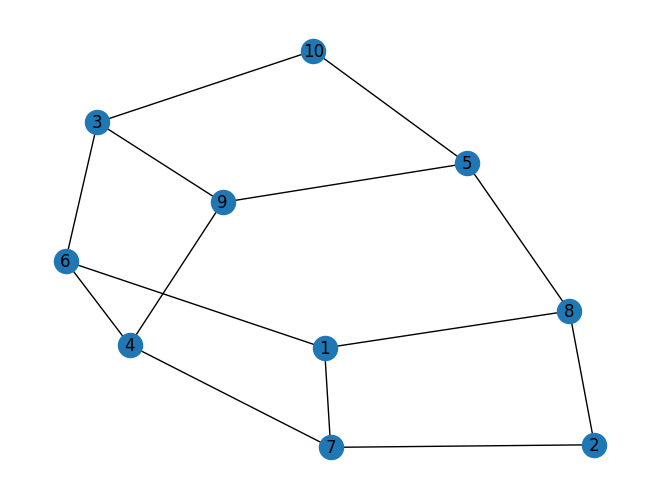

In [4]:
G = network_graph('brunson_southern-women')
res = ust_matrix(G, 6)

print("\n")
for row in res:
  print(row)

# drawing original konect graph
G2 = nx.Graph()
G2.add_edges_from(res[0])
print("\nEredeti gráf:")
nx.draw(G2, with_labels=True)

Példa gráf bemutatása. Az eredeti gráfról láthatunk képet. Ennek a gráfnak 10 pontja és 14 éle van, így több kör is található benne. 6 darab uniform véletlen feszítőfát generáltunk, ami megjelenik a 2D-s tömbben.

> TODO : print kiszervezése metódusba

#### Példa egy mtx-ből beolvasott gráffal


Eredeti gráf:


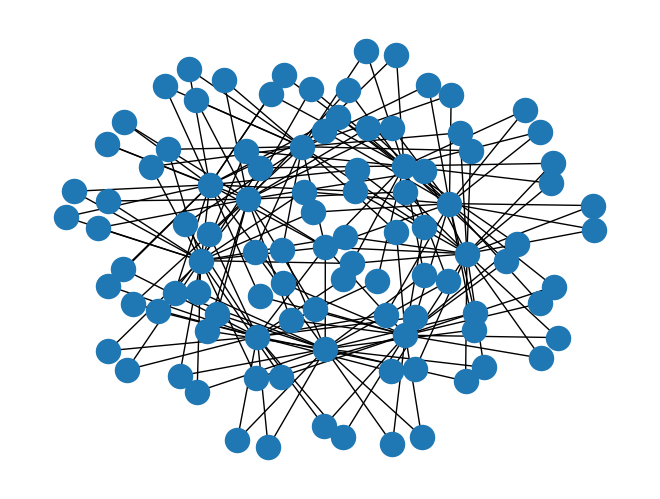

In [181]:
G = network_graph('GD06_theory.mtx')
res = ust_matrix(G, 6)

#print("\n")
#for row in res:
#  print(row)

# plotting a graph with .mtx extension
G2 = nx.Graph()
G2.add_edges_from(res[0])
print("\nEredeti gráf:")
pos = nx.spring_layout(G)
nx.draw(G2, pos, with_labels=False)

Példa egy nagyobb gráfot használva. Ennek a gráfnak 101 pontja és  190 éle van. Most is 6 darab UST-t generáltunk.

## UST gráfok alapján normalizálás

In [6]:
# param: a matrix returned by the ust_matrix() func
def ust_normalized(res):

  number_of_edges = len(res[0])
  number_of_ust = len(res)
  normal_res = [[0 for i in range(number_of_edges)] for j in range(2)]

  # copy edgelist of the original graph
  normal_res[0] = res[0]

  for i in range(1, number_of_ust):
    for j in range(number_of_edges):
      normal_res[1][j] += res[i][j]
   
  # normalization
  for j in range(number_of_edges):
    if (normal_res[1][j] != 0):
      normal_res[1][j] = round(normal_res[1][j]/(number_of_ust-1), 4)

  return normal_res

Paraméterben a *ust_matrix()* függvény által visszaadott 2D-s tömböt kell megadni.<br>A visszatérési érték szintén egy 2D-s tömb lesz, viszont most csak két sora van. Az első ugyanaz a fejléc sor, ami az eredeti gráf éleit tartalmazza, míg a második sor az előző mátrix 0-kat és 1-eseket tartalmazó sorai normalizálva. Most az egyes értékek 0 és 1 közötti float érték. Ha 1 az érték, akkor benne volt az él minden generált véletlen feszítőfában.

## Normalizált értékek megjelenítése grafikusan

In [7]:
## drawing weighted graph
# param: normal_res (a matrix returned by the konect_ust_normalized() func); with_node_labels (bool); with_edge_labels (bool); pos (dict, optional) 
def draw_normalized(normal_res, with_node_labels = False, with_edge_labels = True, with_zero_edges = True, pos = []):
  G = nx.Graph()

  # add edges
  if (with_zero_edges):
    for j in range(len(normal_res[0])):
      G.add_edge(normal_res[0][j][0], normal_res[0][j][1], weight=normal_res[1][j] )
  else:
    for j in range(len(normal_res[0])):
      if (normal_res[1][j] > 0):
        G.add_edge(normal_res[0][j][0], normal_res[0][j][1], weight=normal_res[1][j] )

  elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] >= 0.5]
  esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] < 0.5 and d["weight"] > 0.1]
  enone = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= 0.1]

  # generate new layout if none is provided
  if (len(pos) == 0):
    pos = nx.spring_layout(G)
  
  # nodes and resolution
  if (len(G.edges) > 70):
    plt.figure(num=None, figsize=(16, 16), dpi=50)
    custom_node_size = 50
  else:
    custom_node_size = 70
  
  nx.draw_networkx_nodes(G, pos, node_size=custom_node_size, node_color="#000")

  # edges
  nx.draw_networkx_edges(G, pos, edgelist=elarge, width=3, edge_color="#ce0000")
  nx.draw_networkx_edges(G, pos, edgelist=esmall, width=2, edge_color="#0202ff")
  nx.draw_networkx_edges(G, pos, edgelist=enone, width=2, edge_color="#a2de71")

  # node labels
  if (with_node_labels):
    nx.draw_networkx_labels(G, pos, font_size=7, font_color="#fff")
  
  # edge weight labels
  if (with_edge_labels):
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

  plt.axis('off')
  ax = plt.gca()
  ax.margins(0)
  plt.axis("off")
  plt.tight_layout(pad=0)
  plt.show()

  return pos

Paraméterben a normalizált értékeket tartalmazó tömböt kell megadni. Opcionális paraméterben azt is meg lehet adni, hogy szeretnénk-e a csúcsok vagy az élek címkéit ábrázolni. A *pos* paraméterben egy dictionary típust vár, ami a csúcsok koordinátáit határozza meg.<br>A metódus grafikusan megjeleníti a normalizált feszítőfát. A visszatérési érték a *pos* dictionary, amit vagy paraméterben megadtunk, vagy a függvény generált le. Ez a *pos* érték segítségével tudjuk megjeleníteni ugyanazt a gráfot (ugyanazzal a csúcs-elrendezéssel), a függvény többszöri meghívásával is.

Az eredménygráfban minden él szerepel, ami az eredeti gráfban is szerepelt, viszont a formázása változik a következő módon:
* Ha az él legalább 50% eséllyel fordult elő, akkor vastag piros vonallal jelenik meg.
* Ha kevesebb, mint 50% viszont több, mint 10% esélye van, akkor kék színnel jelenik meg az él.
* Egyébként világoszöld vonal köti össze a pontokat.

Az egyes élekre a normalizált értékük is rá van írva, ha a *with_edge_labels* paraméternek True értéket adtunk meg.

#### Példa egy normalizált konect gráffal

[KONECT2NetworkX] Attemping to download network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] HTTP request successful, writing network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] Network successfully unpacked!


[(1, 6), (1, 7), (1, 8), (2, 7), (2, 8), (3, 6), (3, 9), (3, 10), (4, 6), (4, 9), (4, 7), (5, 9), (5, 8), (5, 10)]
[0.37, 0.2033, 0.24, 0.69, 0.3867, 0.2767, 0.2133, 0.65, 0.6133, 0.6633, 0.2033, 0.4567, 0.6767, 0.5567]


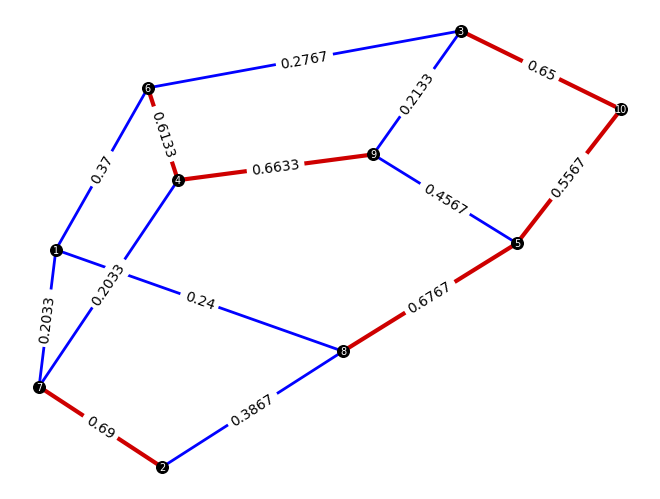

In [14]:
G = network_graph('brunson_southern-women')
res = ust_matrix(G, 300)
normal_res1 = ust_normalized(res)

print("\n")
for row in normal_res1:
  print(row)

pos1 = draw_normalized(normal_res1, with_node_labels = True)

Az előbb is használt konect gráfot vettük példának, de most 300 UST-t generáltunk, hogy pontosabb normalizált értékeket kapjunk.<br>A példán látszik, hogy melyik élek bírnak a legnagyobb jelentőséggel.

Az eredményről leolvashatóak a csúcspontok nevei (számai) és az élek súlyainak értékei.

#### Példa egy normalizált, mtx-ből beolvasott gráffal

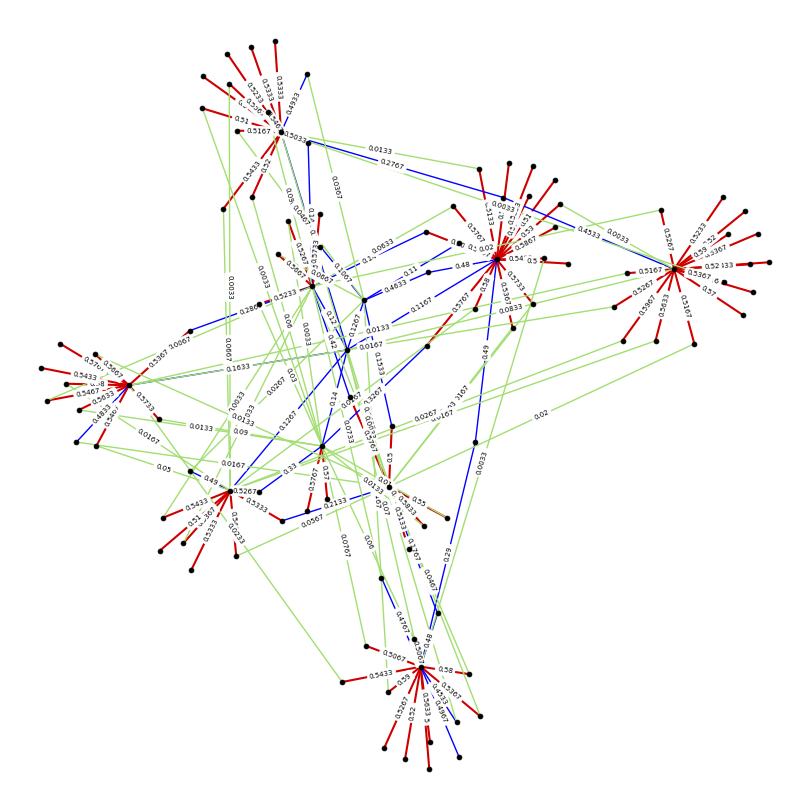

In [20]:
G = network_graph('GD06_theory.mtx')
res = ust_matrix(G, 300)
normal_res2 = ust_normalized(res)

#print("\n")
#for row in normal_res2:
#  print(row)

pos2 = draw_normalized(normal_res2, False, True, False)

Ez esetben is 300 feszítőfát generáltunk, viszont előfordul olyan él, ami 0 eséllyel fordul elő az UST-kben. Ezeket a 0 súllyal rendelkező éleket most nem jelenítjük meg a gráfban (4. paraméter).

#### Példa gráf pont- és élcímkék nélkül

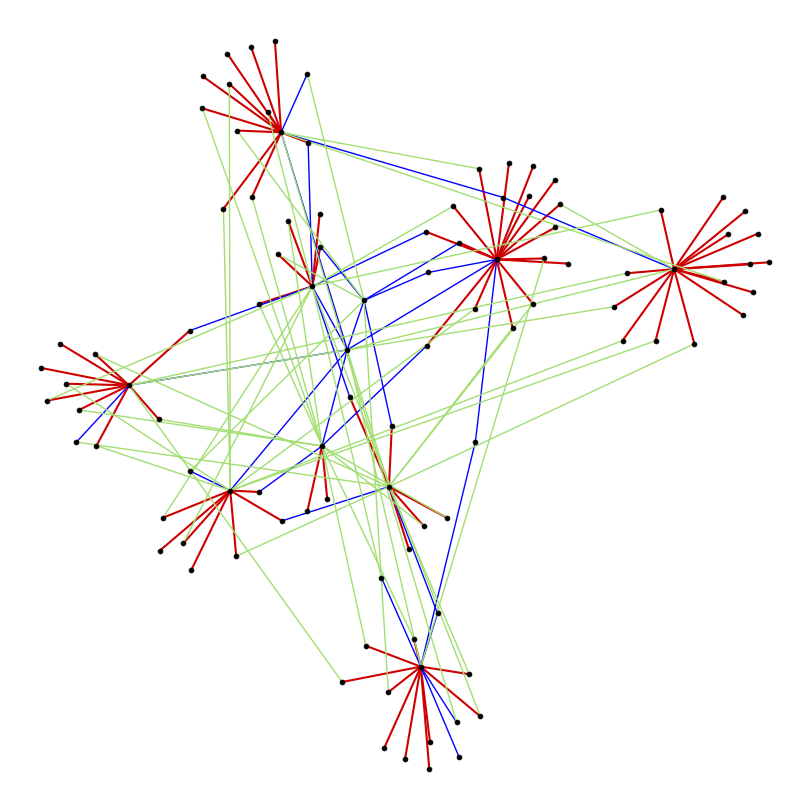

In [21]:
pos3 = draw_normalized(normal_res2, False, False, False, pos2)

Ez ugyanaz a normalizált gráf, amit eggyel feljebb is látunk.

## 2. Betweenness centrality használata

Központisági mérőszám. A gráfban meghatározzuk a legrövidebb utakat minden csomópontpár között. Egy pont BC értéke ezeken az utakon alapul aszerint, hogy hány ilyen legrövidebb út tartalmazza. Értéke 0 és 1 között lehet, ahol 1 a maximum érték.

In [26]:
G = network_graph('brunson_southern-women')

[KONECT2NetworkX] Attemping to download network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] HTTP request successful, writing network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] Network successfully unpacked!


In [28]:
res = nx.betweenness_centrality(G)
res_e = nx.edge_betweenness_centrality(G)

print('#--- nx.betweenness_centrality ---#\n')
pprint.pprint(res)
print('\n#--- nx.edge_betweenness_centrality ---#\n')
pprint.pprint(res_e)

#--- nx.betweenness_centrality ---#

{1: 0.1412037037037037,
 2: 0.03472222222222222,
 3: 0.12268518518518516,
 4: 0.15046296296296294,
 5: 0.18981481481481483,
 6: 0.15046296296296294,
 7: 0.12268518518518516,
 8: 0.18981481481481483,
 9: 0.1412037037037037,
 10: 0.034722222222222224}

#--- nx.edge_betweenness_centrality ---#

{(1, 6): 0.16296296296296298,
 (1, 7): 0.11111111111111112,
 (1, 8): 0.15185185185185185,
 (2, 7): 0.12037037037037036,
 (2, 8): 0.13518518518518519,
 (3, 6): 0.1648148148148148,
 (3, 9): 0.11111111111111112,
 (3, 10): 0.12037037037037036,
 (4, 6): 0.11296296296296296,
 (4, 7): 0.1648148148148148,
 (4, 9): 0.16296296296296298,
 (5, 8): 0.21666666666666665,
 (5, 9): 0.15185185185185185,
 (5, 10): 0.1351851851851852}


Beszélhetünk betweenness centrality-ről vagy edge betwenness centrality-ről. Az első a pontok központiságát írja le, míg a második az egyes éleket karakterizálja.<br>Mivel az UST gráfokkal az éleket vizsgáltam, így most az edge betwenness centrality értékkel fogok mélyebben foglalkozni a továbbiakban.

> TODO : hasonlóan megrajzolni a gráfok éleit, mint a draw_normalized() metódusomban az ust-ket

#### Segédfüggvények az éllista adatszerkezetének változtatásához
Dictionary-ból tömbbé alakítás (vagy fordítva).

In [12]:
def dict_to_array(dict_name):
  res_arr = [[0 for i in range(0, len(dict_name.keys()))] for j in range(2)]
  
  i = 0
  for k, v in dict_name.items():
      res_arr[0][i] = k
      res_arr[1][i] = round(v, 4)
      i+=1

  return res_arr

In [2]:
def array_to_dict(array_name):
  res_d = dict(zip(array_name[0], array_name[1]))
  return res_d

### Példa: edge betweenness ábrázolása egy konect gráffal

[KONECT2NetworkX] Attemping to download network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] HTTP request successful, writing network to brunson_southern-women.tar.bz2
[KONECT2NetworkX] Network successfully unpacked!


[(1, 6), (1, 7), (1, 8), (2, 7), (2, 8), (3, 6), (3, 9), (3, 10), (4, 6), (4, 9), (4, 7), (5, 9), (5, 8), (5, 10)]
[0.163, 0.1111, 0.1519, 0.1204, 0.1352, 0.1648, 0.1111, 0.1204, 0.113, 0.163, 0.1648, 0.1519, 0.2167, 0.1352]


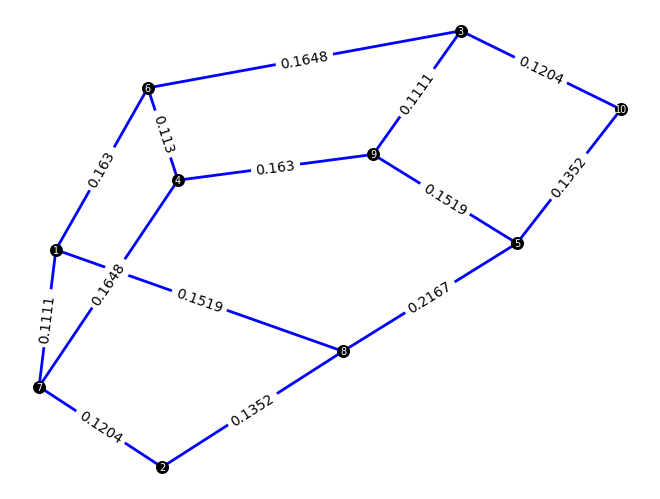

In [16]:
G = network_graph('brunson_southern-women')
res_e = nx.edge_betweenness_centrality(G)

res_e_array = dict_to_array(res_e)

print("\n")
for row in res_e_array:
  print(row)

pos4 = draw_normalized(res_e_array, with_node_labels = True, pos = pos1)

#### Példa: edge betweenness ábrázolása egy .mtx gráffal

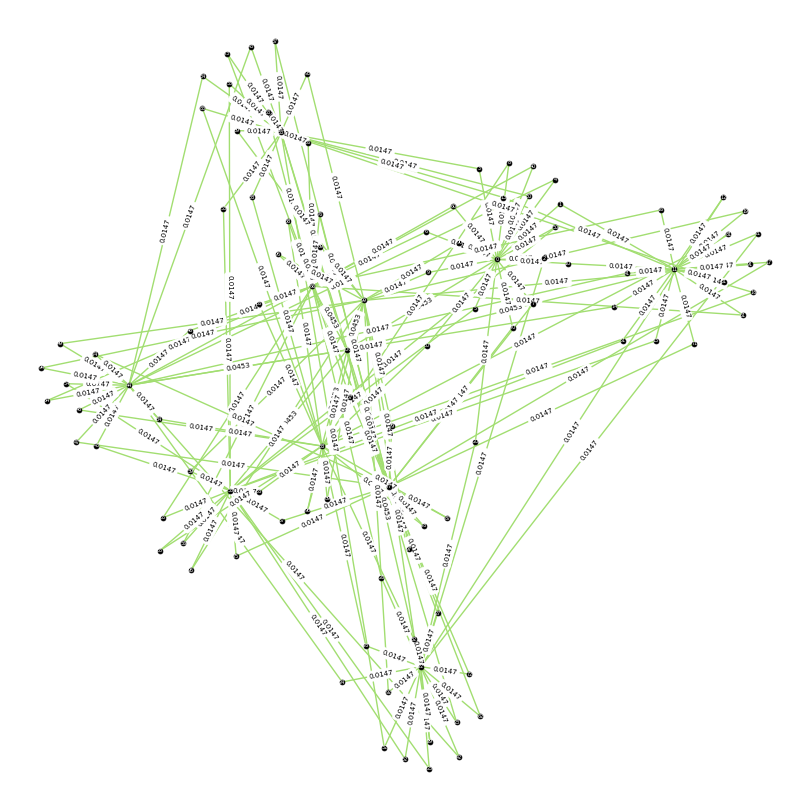

In [23]:
G = network_graph('GD06_theory.mtx')
res_e = nx.edge_betweenness_centrality(G)

res_e_array = dict_to_array(res_e)

pos4 = draw_normalized(res_e_array, with_node_labels = True, pos = pos2)